In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential


#Read the input files
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
store = pd.read_csv('stores.csv')
feature = pd.read_csv('features.csv')


train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])
feature['Date']=pd.to_datetime(feature['Date'])

# Splitting month, year and day - train
train['Month']=train['Date'].dt.month
train['Year']=train['Date'].dt.year
train['Dayofweek']=train['Date'].dt.dayofweek

# Splitting month, year and day - test
test['Month']=test['Date'].dt.month
test['Year']=test['Date'].dt.year
test['Dayofweek']=test['Date'].dt.dayofweek

# set the dates as the index of the dataframe, so that it can be treated as a time-series dataframe
train.set_index('Date',inplace=True)
test.set_index('Date',inplace=True)


#Merge train and feature
merge_df=pd.merge(train,feature, on=['Store','Date','IsHoliday'], how='inner')
merge_df = pd.merge(merge_df, store, on='Store', how='inner')

print(merge_df)

        Store       Date  Dept  Weekly_Sales  IsHoliday  Month  Year  \
0           1 2010-02-05     1      24924.50      False      2  2010   
1           1 2010-02-05     2      50605.27      False      2  2010   
2           1 2010-02-05     3      13740.12      False      2  2010   
3           1 2010-02-05     4      39954.04      False      2  2010   
4           1 2010-02-05     5      32229.38      False      2  2010   
...       ...        ...   ...           ...        ...    ...   ...   
421565     45 2012-10-26    93       2487.80      False     10  2012   
421566     45 2012-10-26    94       5203.31      False     10  2012   
421567     45 2012-10-26    95      56017.47      False     10  2012   
421568     45 2012-10-26    97       6817.48      False     10  2012   
421569     45 2012-10-26    98       1076.80      False     10  2012   

        Dayofweek  Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  \
0               4        42.31       2.572        NaN   

In [2]:
def understand_data(stores, train, test, features):
    print("Getting Table info: ")
    print("Stores: ")
    print(stores.info())
    print("Train: ")
    print(train.info())
    print("Test: ")
    print(test.info())
    print("Features: ")
    print(features.info())

In [3]:
def check_missing_values(stores,train, test, features):
    print("Printing missing values in the table")
    print("Stores:" + str(stores.isnull().sum()))
    print("Train : " + str(train.isnull().sum()))
    print("Test : " + str(test.isnull().sum()))
    print("Features : " + str(features.isnull().sum()))

In [4]:
def rolling_average(train):
    sales = train.groupby('Date')['Weekly_Sales'].sum()
    months = [4, 6, 8, 12]
    fig, axes = plt.subplots(2, 2, figsize=(12, 7))

    for i, ax in enumerate(axes.flatten()):
        wsize = months[i]
        ax.plot(sales.index, sales, label='Original')
        ax.plot(sales.index, sales.rolling(window=wsize).mean(),
                label=str(wsize)+"-Months Rolling Mean")
        ax.set_title(str(wsize)+"-Months Moving Average")
        ax.set_xlabel("Years")
        ax.set_ylabel("Sales")
        ax.legend(loc='best')

    plt.tight_layout()
    plt.show()

In [5]:
def plot_correlation_matrix():
    #Considering only the numneric columns for plotting correlation matrix
    nc=merge_df.select_dtypes(include=[np.number]).columns
    correlationmatrix = merge_df[nc].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlationmatrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.show()
    #Observation: There is no linear relationship between dependant and non-dependant variables

In [6]:
def plot_monthly_sales_graph():
    m_sales = pd.pivot_table(train, values = "Weekly_Sales", columns = "Year", index = "Month")
    m = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    plt.plot(m_sales)
    plt.title('Monthly Sales')
    plt.xlabel('Month')
    plt.ylabel('Sales')
    plt.xticks(range(1, 13), m)
    print(plt.show())

In [7]:
def plot_holiday_nonholiday_graph(merge_df):
    merge_df = merge_df.set_index('Date').sort_index()
    plt.figure(figsize=(8, 6))
    plt.plot(merge_df[merge_df['IsHoliday'] == 1]['Weekly_Sales'], marker='s', linestyle='-',
             color='black',label='Sales on Holidays')
    plt.plot(merge_df[merge_df['IsHoliday'] == 0]['Weekly_Sales'], marker='o', linestyle='--',
             color='cyan',label='Sales on Non-Holidays')

    plt.title('Comparing sales on Holidays vs Non-Holidays')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

In [8]:
def CompareModels(data):
    test.drop('Predicted_Weekly_Sales', axis=1, inplace=True)
    features = ['Store', 'Dept', 'IsHoliday', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

    train_set=data[features + ['Weekly_Sales']]
    X_train, X_test, y_train, y_test = train_test_split(train_set[features], train_set['Weekly_Sales'], test_size=0.2,
                                                        random_state=42)
    # Random Forest
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # XGBoost
    xgb_model = XGBRegressor(n_estimators=100, random_state=42)
    xgb_model.fit(X_train, y_train)

    # LSTM
    # Build LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    # LSTM_model = LSTM(n_estimators=100, random_state=42)
    # LSTM_model.fit(X_train, y_train, epochs=1, batch_size=32)

    # Predict and plot for LSTMoost
    PredictAndPlot(LSTM_model, test, 'LSTM')
    lstm_model = LSTM(n_n_estimators = 100 , random_state = 42)
    lstm_model.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_test, y_test))
    
    # Making predictions
    rf_preds = rf_model.predict(X_test)
    mae = mean_absolute_error(y_test, rf_preds)
    print("Random Forest - MAE :"+str(mae))
    rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
    print("Random Forest - RMSE :"+str(rmse))
    accuracy = 1 - mae / np.mean(y_test)
    print("Random Forest - Accuracy : "+str(+accuracy*100)+"%")

    xgb_preds = xgb_model.predict(X_test)
    mae = mean_absolute_error(y_test, xgb_preds)
    print("XGBoost - MAE :" + str(mae))
    rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
    print("XGBoost - RMSE :" + str(rmse))
    accuracy = 1 - mae / np.mean(y_test)
    print("XGBoost - Accuracy : " + str(accuracy*100)+"%")

    lstm_preds = xgb_model.predict(X_test)
    mae = mean_absolute_error(y_test, lstm_preds)
    print("LSTM - MAE :" + str(mae))
    rmse = np.sqrt(mean_squared_error(y_test, lstm_preds))
    print("LSTM - RMSE :" + str(rmse))
    accuracy = 1 - mae / np.mean(y_test)
    print("LSTM - Accuracy : " + str(accuracy*100)+"%")
    
    # Plotting results
    plt.figure(figsize=(14, 7))

    plt.plot(y_test.index, y_test.values, label='Actual Sales', color='black')
    plt.plot(y_test.index, rf_preds, label='Random Forest Predictions', color='blue')
    plt.plot(y_test.index, xgb_preds, label='XG Boost Predictions', color='red')
    plt.plot(y_test.index, lstm_preds, label='LSTM Predictions', color='green')

    plt.xlabel('Date')
    plt.ylabel('Weekly Sales')
    plt.title(f'Sales Prediction Comparison')
    plt.legend()
    plt.show()
    
print("Comparing models")

Comparing models


In [9]:
#CompareModels(merge_df)

def PredictAndPlot(model, X_test, name):
    print("Making predictions")
    preds = model.predict(X_test)
    pred_df = pd.DataFrame({ 'Date': test.index,'predicted_sales': preds })
    group_pred = pred_df.groupby('Date').mean()
    # Plot graph
    plt.figure(figsize=(8, 6))
    plt.plot(group_pred.index, group_pred['predicted_sales'],
             color='red',label='Predictions')
    plt.title(name + " - Sales Prediction")
    plt.xlabel('Date')
    plt.ylabel('Weekly Sales')
    plt.legend()
    plt.show()

def FeatureEngineering(merge_df):
    merge_df['Prev_Week_Sales'] = merge_df['Weekly_Sales'].shift(1)
    plt.figure(figsize=(8, 6))
    plt.plot(merge_df.index, merge_df['Weekly_Sales'], label='Current Week Sales', color='blue')
    plt.plot(merge_df.index, merge_df['Prev_Week_Sales'], label='Previous Week Sales', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Weekly Sales')
    plt.legend()
    plt.title('Current vs Lagged Weekly Sales')
    plt.show()

Getting Table info: 
Stores: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB
None
Train: 
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Weekly_Sales  421570 non-null  float64
 3   IsHoliday     421570 non-null  bool   
 4   Month         421570 non-null  int32  
 5   Year          421570 non-null  int32  
 6   Dayofweek     421570 non-null  int32  
dtypes: bool(1), float64(1), int32(3), int64(2)
memory usage: 18.1 MB
None
Test: 
<class 'pandas.core.f

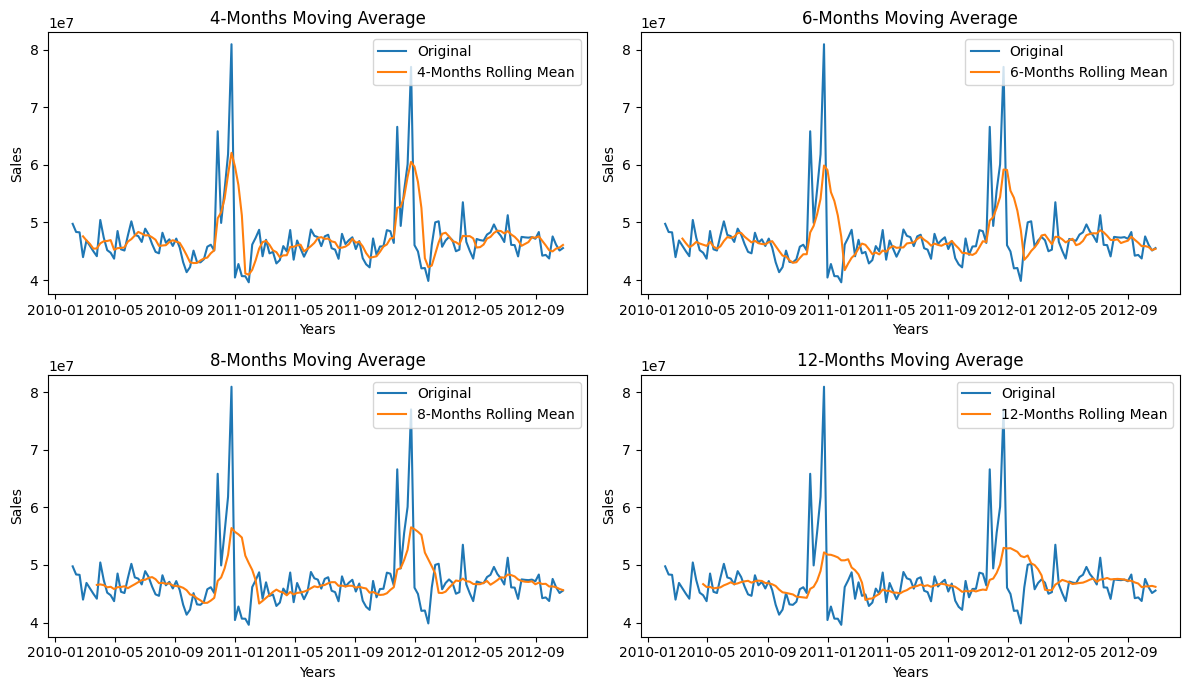

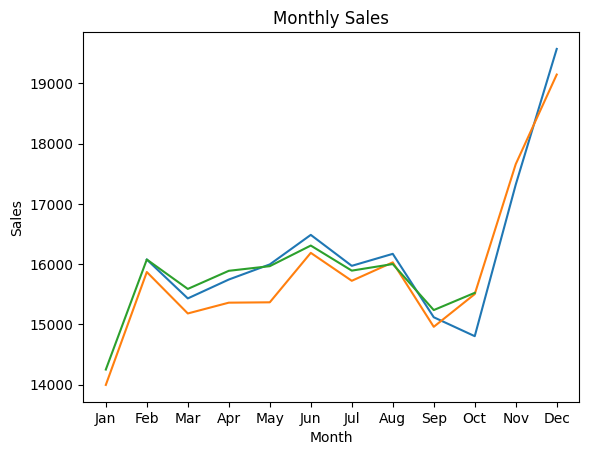

None


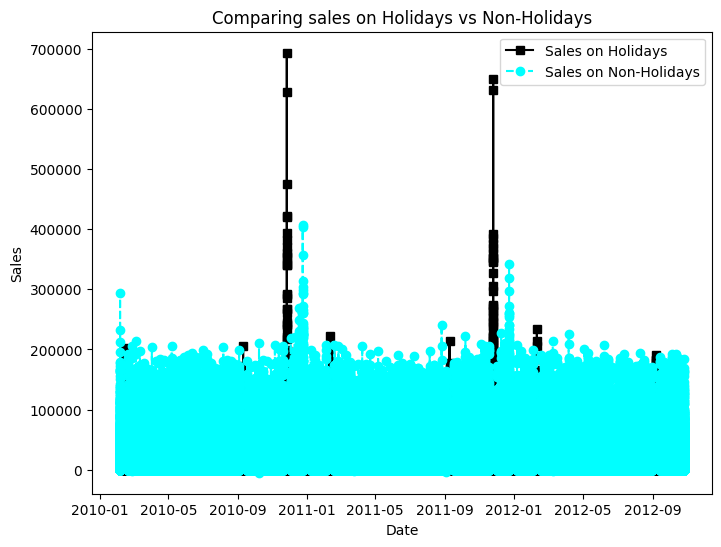

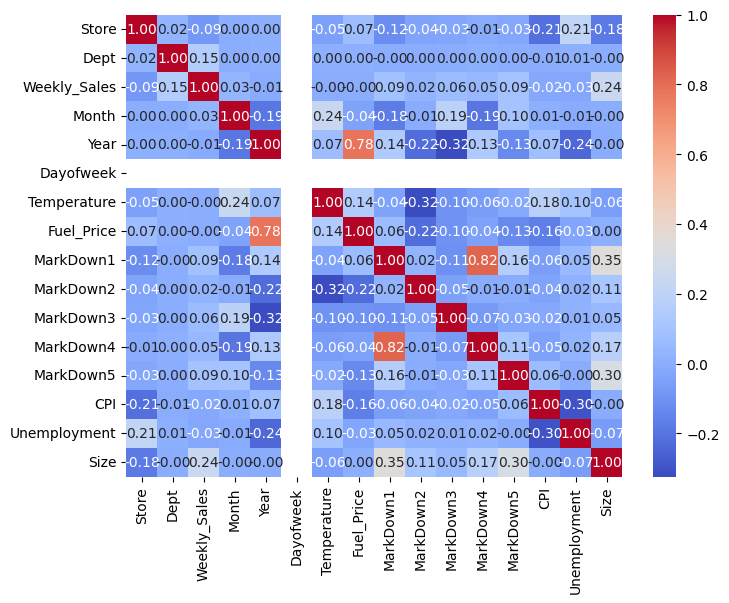

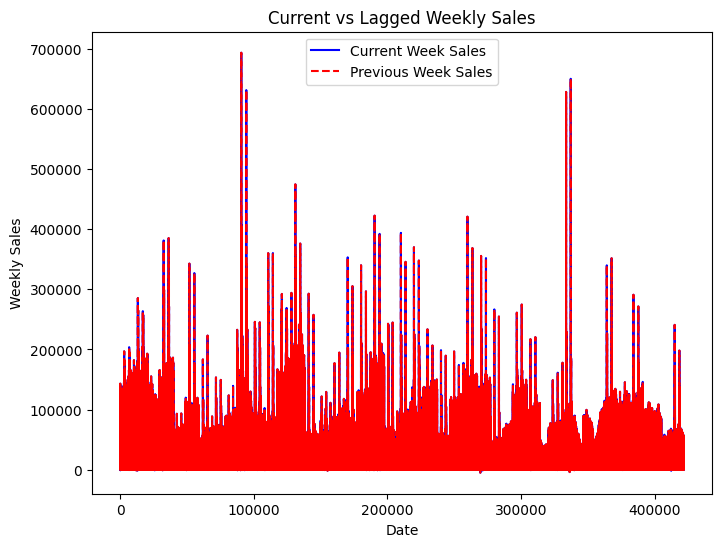

In [10]:

# Step 1: Understanding the data:
understand_data(store,train,test,feature)
check_missing_values(store,train,test,feature)

rolling_average(train)
#Plot monthlty sales
plot_monthly_sales_graph()
#Plot weekly sales
plot_holiday_nonholiday_graph(merge_df)
#Plot Heat map for correlatopn
plot_correlation_matrix()

FeatureEngineering(merge_df)
y_train=train["Weekly_Sales"]
X_train=train.drop("Weekly_Sales", axis=1)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and plot for Random Forest
PredictAndPlot(rf_model, test, 'Random Forest')

# Train XGBoost model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and plot for XGBoost
PredictAndPlot(xgb_model, test, 'XGBoost')







In [ ]:
print(X_train.columns)


Index(['Store', 'Dept', 'IsHoliday', 'Month', 'Year', 'Dayofweek'], dtype='object')


In [ ]:
print(y_train)

Date
2010-02-05    24924.50
2010-02-12    46039.49
2010-02-19    41595.55
2010-02-26    19403.54
2010-03-05    21827.90
                ...   
2012-09-28      508.37
2012-10-05      628.10
2012-10-12     1061.02
2012-10-19      760.01
2012-10-26     1076.80
Name: Weekly_Sales, Length: 421570, dtype: float64
